# STD Validation - Price validation

In [199]:
from qpython import qconnection 
import requests
from requests_kerberos import HTTPKerberosAuth
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv(r"W:\UK\Risk_Control\Risk_Control_Public\MiddleOffice\Alteryx\Singapore\Output_price_check_power.csv")

## Monthly Prices

In [200]:
France_bl  = data.loc[(data["Index_profile"] == "FRANCE_BL") & (data["Contract_type"] == "Month") , :]
France_bl["start_date"] = pd.to_datetime(France_bl["start_date"])
France_bl["Max"] = France_bl.loc[:, ["Ice", "EEX", "Markit", "Skylight"]].max(axis = 1)
France_bl["Min"]  = France_bl.loc[:, ["Ice", "EEX", "Markit", "Skylight"]].min(axis = 1)

France_bl["Validated with std"] = np.where( abs(France_bl["TGP"]  - France_bl["Markit"]) > France_bl["Markit Std"], 0, 1 )
France_bl["Validated with 2 prices"] = np.where((France_bl["Max"]> France_bl["TGP"]) & (France_bl["TGP"]> France_bl["Min"]),1,0 )

France_bl.dropna(subset = ["Markit"], inplace = True)
France_bl = round(France_bl,3)
France_bl.head()

,Index_profile,Contract_type,start_date,TGP,Ice,EEX,Markit,Markit Std,Skylight,Max,Min,Validated with std,Validated with 2 prices
407,FRANCE_BL,Month,2022-09-01,670.000,649.90,661.48,657.800,7.040,652.957,661.480,649.900,0,0
408,FRANCE_BL,Month,2022-10-01,715.000,710.99,711.39,704.733,8.993,710.727,711.390,704.733,0,0
409,FRANCE_BL,Month,2022-11-01,1310.424,1237.88,1254.76,1201.265,90.115,1263.244,1263.244,1201.265,0,0
410,FRANCE_BL,Month,2022-12-01,1251.686,1243.07,1223.21,1239.918,75.754,1230.222,1243.070,1223.210,1,0
411,FRANCE_BL,Month,2023-01-01,1308.582,1336.06,1358.68,1269.429,55.686,1241.284,1358.680,1241.284,1,1


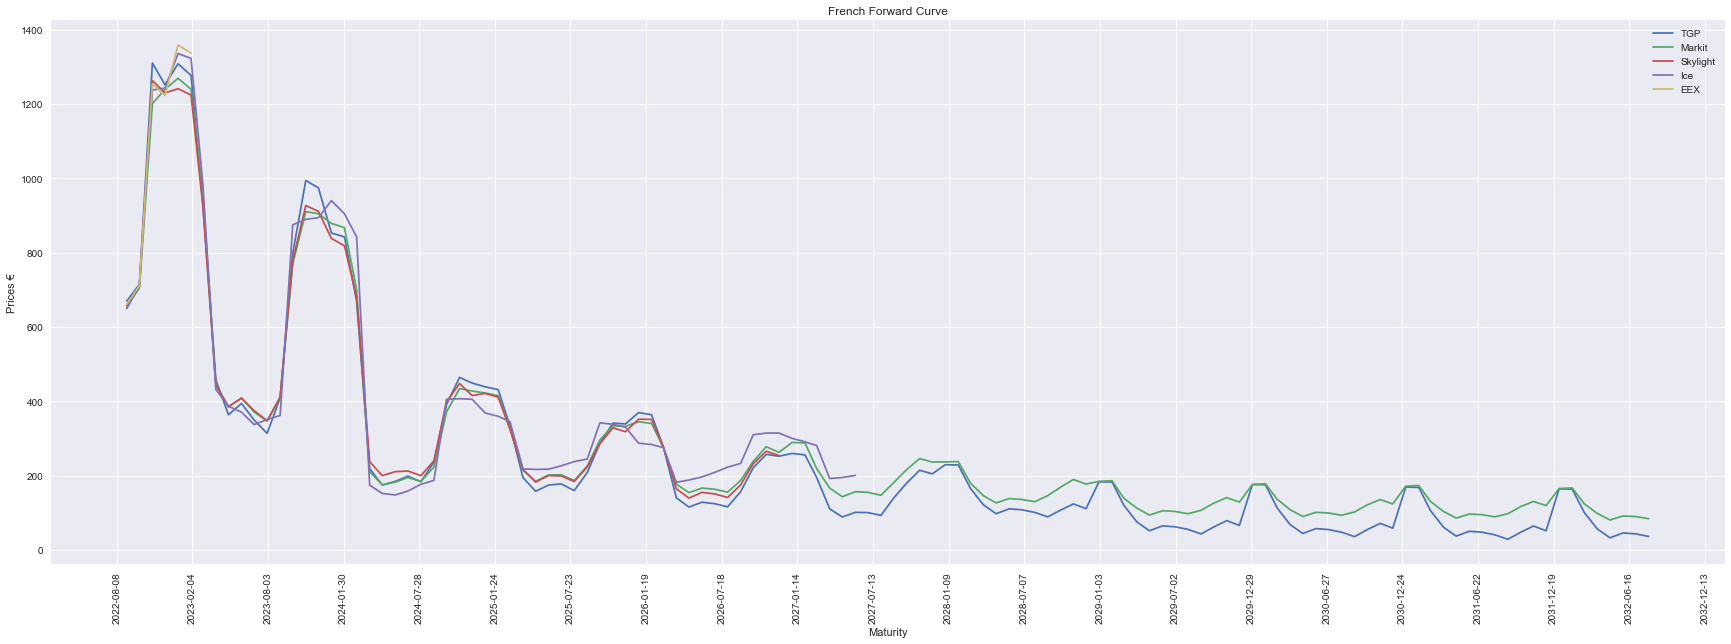

In [201]:
plt.figure(figsize = (30, 10))
plt.plot(France_bl["start_date"] , France_bl["TGP"], label = "TGP")
plt.plot(France_bl["start_date"] , France_bl["Markit"], label = "Markit")
plt.plot(France_bl["start_date"] , France_bl["Skylight"], label = "Skylight")
plt.plot(France_bl["start_date"] , France_bl["Ice"], label = "Ice")
plt.plot(France_bl["start_date"] , France_bl["EEX"], label = "EEX")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title("French Forward Curve")
plt.xlabel("Maturity")
plt.ylabel("Prices €")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 180))
plt.legend()
plt.xticks(rotation=90); 

In [202]:
France_bl["Markit Delta"] = France_bl["TGP"] - France_bl["Markit"]
France_bl["Ice Delta"] = France_bl["TGP"] - France_bl["Ice"]
France_bl["EEX Delta"] = France_bl["TGP"] - France_bl["EEX"]
France_bl["Skylight Delta"] = France_bl["TGP"] - France_bl["Skylight"]
France_bl["Max | Min Delta"] = (France_bl["Max"] - France_bl["Min"])
France_bl["Max | Min Delta %"] = (France_bl["Max"] - France_bl["Min"]) * 100 / France_bl["Markit"]
France_bl = round(France_bl,3)
France_bl.head()

,Index_profile,Contract_type,start_date,TGP,Ice,EEX,Markit,Markit Std,Skylight,Max,Min,Validated with std,Validated with 2 prices,Markit Delta,Ice Delta,EEX Delta,Skylight Delta,Max | Min Delta,Max | Min Delta %
407,FRANCE_BL,Month,2022-09-01,670.000,649.90,661.48,657.800,7.040,652.957,661.480,649.900,0,0,12.200,20.100,8.520,17.043,11.580,1.760
408,FRANCE_BL,Month,2022-10-01,715.000,710.99,711.39,704.733,8.993,710.727,711.390,704.733,0,0,10.267,4.010,3.610,4.273,6.657,0.945
409,FRANCE_BL,Month,2022-11-01,1310.424,1237.88,1254.76,1201.265,90.115,1263.244,1263.244,1201.265,0,0,109.159,72.544,55.664,47.180,61.979,5.159
410,FRANCE_BL,Month,2022-12-01,1251.686,1243.07,1223.21,1239.918,75.754,1230.222,1243.070,1223.210,1,0,11.768,8.616,28.476,21.464,19.860,1.602
411,FRANCE_BL,Month,2023-01-01,1308.582,1336.06,1358.68,1269.429,55.686,1241.284,1358.680,1241.284,1,1,39.153,-27.478,-50.098,67.298,117.396,9.248


In [203]:
print(round(France_bl["Max | Min Delta %"].mean(),2))
print(round(France_bl["Max | Min Delta"].mean(),2))


7.17
21.94


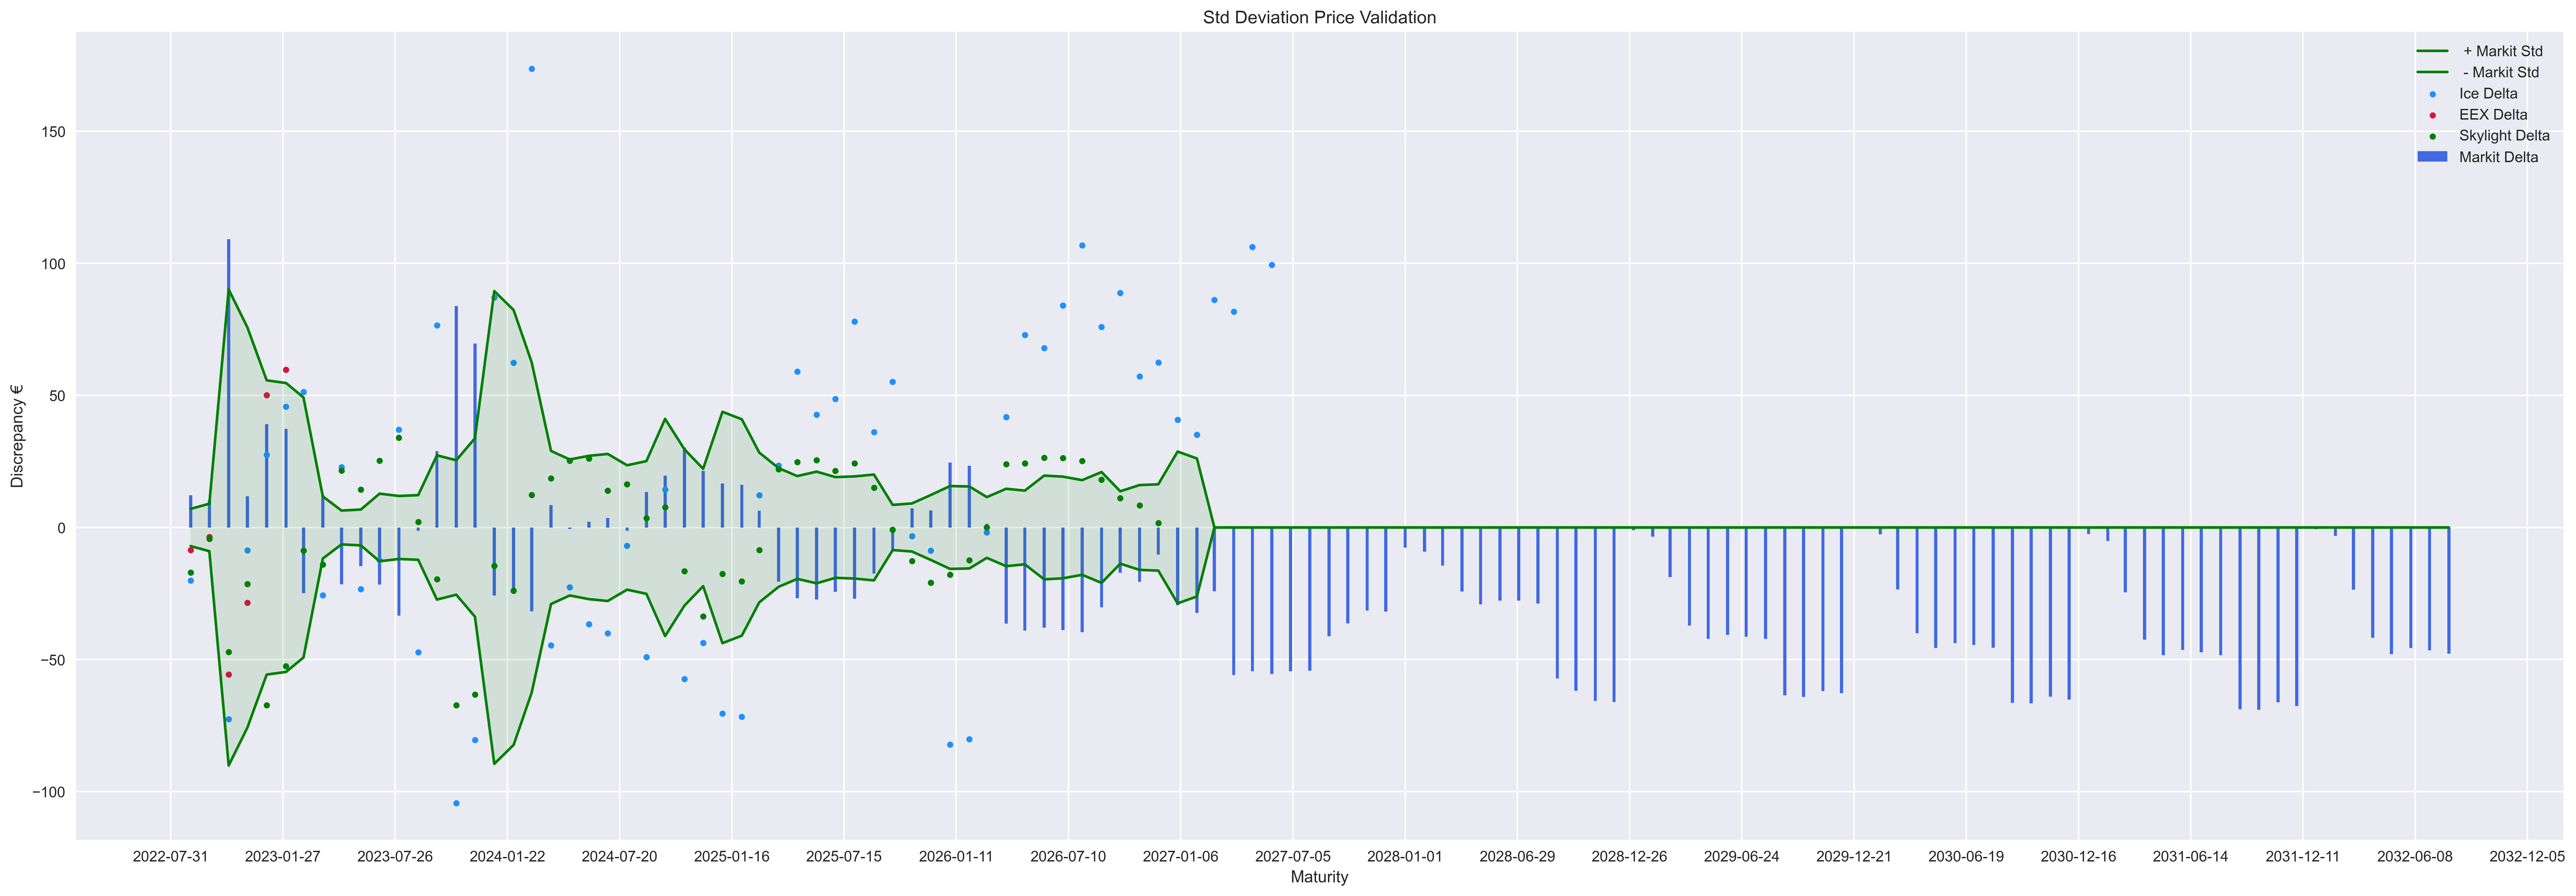

In [204]:
plt.figure(figsize = (30, 10), dpi = 400)
plt.bar(France_bl["start_date"] , France_bl["Markit Delta"], width = 5 ,  label = "Markit Delta", color = 'royalblue')
plt.plot(France_bl["start_date"] , France_bl["Markit Std"], label = " + Markit Std",  color = 'g')
plt.plot(France_bl["start_date"] , -France_bl["Markit Std"], label = " - Markit Std",  color = 'g')
plt.scatter(France_bl["start_date"] , -France_bl["Ice Delta"], label = "Ice Delta",  color = 'dodgerblue', marker = 'o', s = 15)
plt.scatter(France_bl["start_date"] , -France_bl["EEX Delta"], label = "EEX Delta",  color = 'crimson', marker = 'o', s = 15)
plt.scatter(France_bl["start_date"] , -France_bl["Skylight Delta"], label = "Skylight Delta",  color = 'g', marker = 'o', s = 15)
plt.fill_between(France_bl["start_date"], France_bl["Markit Std"], -France_bl["Markit Std"] , alpha = 0.1, color = 'g')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 180))
plt.title("Std Deviation Price Validation")
plt.xlabel("Maturity")
plt.ylabel("Discrepancy €")
plt.legend();

## Quarterly Prices

In [205]:
France_bl  = data.loc[(data["Index_profile"] == "FRANCE_BL") & (data["Contract_type"] == "Quarter") , :]
France_bl["start_date"] = pd.to_datetime(France_bl["start_date"])
France_bl["Max"] = France_bl.loc[:, ["Ice", "EEX", "Markit", "Skylight"]].max(axis = 1)
France_bl["Min"]  = France_bl.loc[:, ["Ice", "EEX", "Markit", "Skylight"]].min(axis = 1)

France_bl["Validated with std"] = np.where( abs(France_bl["TGP"]  - France_bl["Markit"]) > France_bl["Markit Std"], 0, 1 )
France_bl["Validated with 2 prices"] = np.where((France_bl["Max"]> France_bl["TGP"]) & (France_bl["TGP"]> France_bl["Min"]),1,0 )

France_bl.dropna(subset = ["Markit"], inplace = True)
France_bl = round(France_bl,3)
France_bl.head()

,Index_profile,Contract_type,start_date,TGP,Ice,EEX,Markit,Markit Std,Skylight,Max,Min,Validated with std,Validated with 2 prices
366,FRANCE_BL,Quarter,2022-10-01,1090.000,NaN,1060.88,1038.948,24.291,1065.943,1065.943,1038.948,0,0
367,FRANCE_BL,Quarter,2023-01-01,1170.000,NaN,1193.89,1154.613,37.293,1135.774,1193.890,1135.774,1,1
368,FRANCE_BL,Quarter,2023-04-01,405.226,NaN,415.37,413.643,3.717,411.668,415.370,411.668,0,0
369,FRANCE_BL,Quarter,2023-07-01,357.486,NaN,370.22,378.039,8.806,377.266,378.039,370.220,0,0
370,FRANCE_BL,Quarter,2023-10-01,921.910,NaN,867.98,859.949,16.447,865.566,867.980,859.949,0,0


In [206]:
France_bl["Markit Delta"] = France_bl["TGP"] - France_bl["Markit"]
France_bl["Ice Delta"] = France_bl["TGP"] - France_bl["Ice"]
France_bl["EEX Delta"] = France_bl["TGP"] - France_bl["EEX"]
France_bl["Skylight Delta"] = France_bl["TGP"] - France_bl["Skylight"]
France_bl["Max | Min Delta"] = (France_bl["Max"] - France_bl["Min"])
France_bl["Max | Min Delta %"] = (France_bl["Max"] - France_bl["Min"]) * 100 / France_bl["Markit"]
France_bl = round(France_bl,3)
France_bl.head()

,Index_profile,Contract_type,start_date,TGP,Ice,EEX,Markit,Markit Std,Skylight,Max,Min,Validated with std,Validated with 2 prices,Markit Delta,Ice Delta,EEX Delta,Skylight Delta,Max | Min Delta,Max | Min Delta %
366,FRANCE_BL,Quarter,2022-10-01,1090.000,NaN,1060.88,1038.948,24.291,1065.943,1065.943,1038.948,0,0,51.052,NaN,29.120,24.057,26.995,2.598
367,FRANCE_BL,Quarter,2023-01-01,1170.000,NaN,1193.89,1154.613,37.293,1135.774,1193.890,1135.774,1,1,15.387,NaN,-23.890,34.226,58.116,5.033
368,FRANCE_BL,Quarter,2023-04-01,405.226,NaN,415.37,413.643,3.717,411.668,415.370,411.668,0,0,-8.417,NaN,-10.144,-6.442,3.702,0.895
369,FRANCE_BL,Quarter,2023-07-01,357.486,NaN,370.22,378.039,8.806,377.266,378.039,370.220,0,0,-20.553,NaN,-12.734,-19.780,7.819,2.068
370,FRANCE_BL,Quarter,2023-10-01,921.910,NaN,867.98,859.949,16.447,865.566,867.980,859.949,0,0,61.961,NaN,53.930,56.344,8.031,0.934


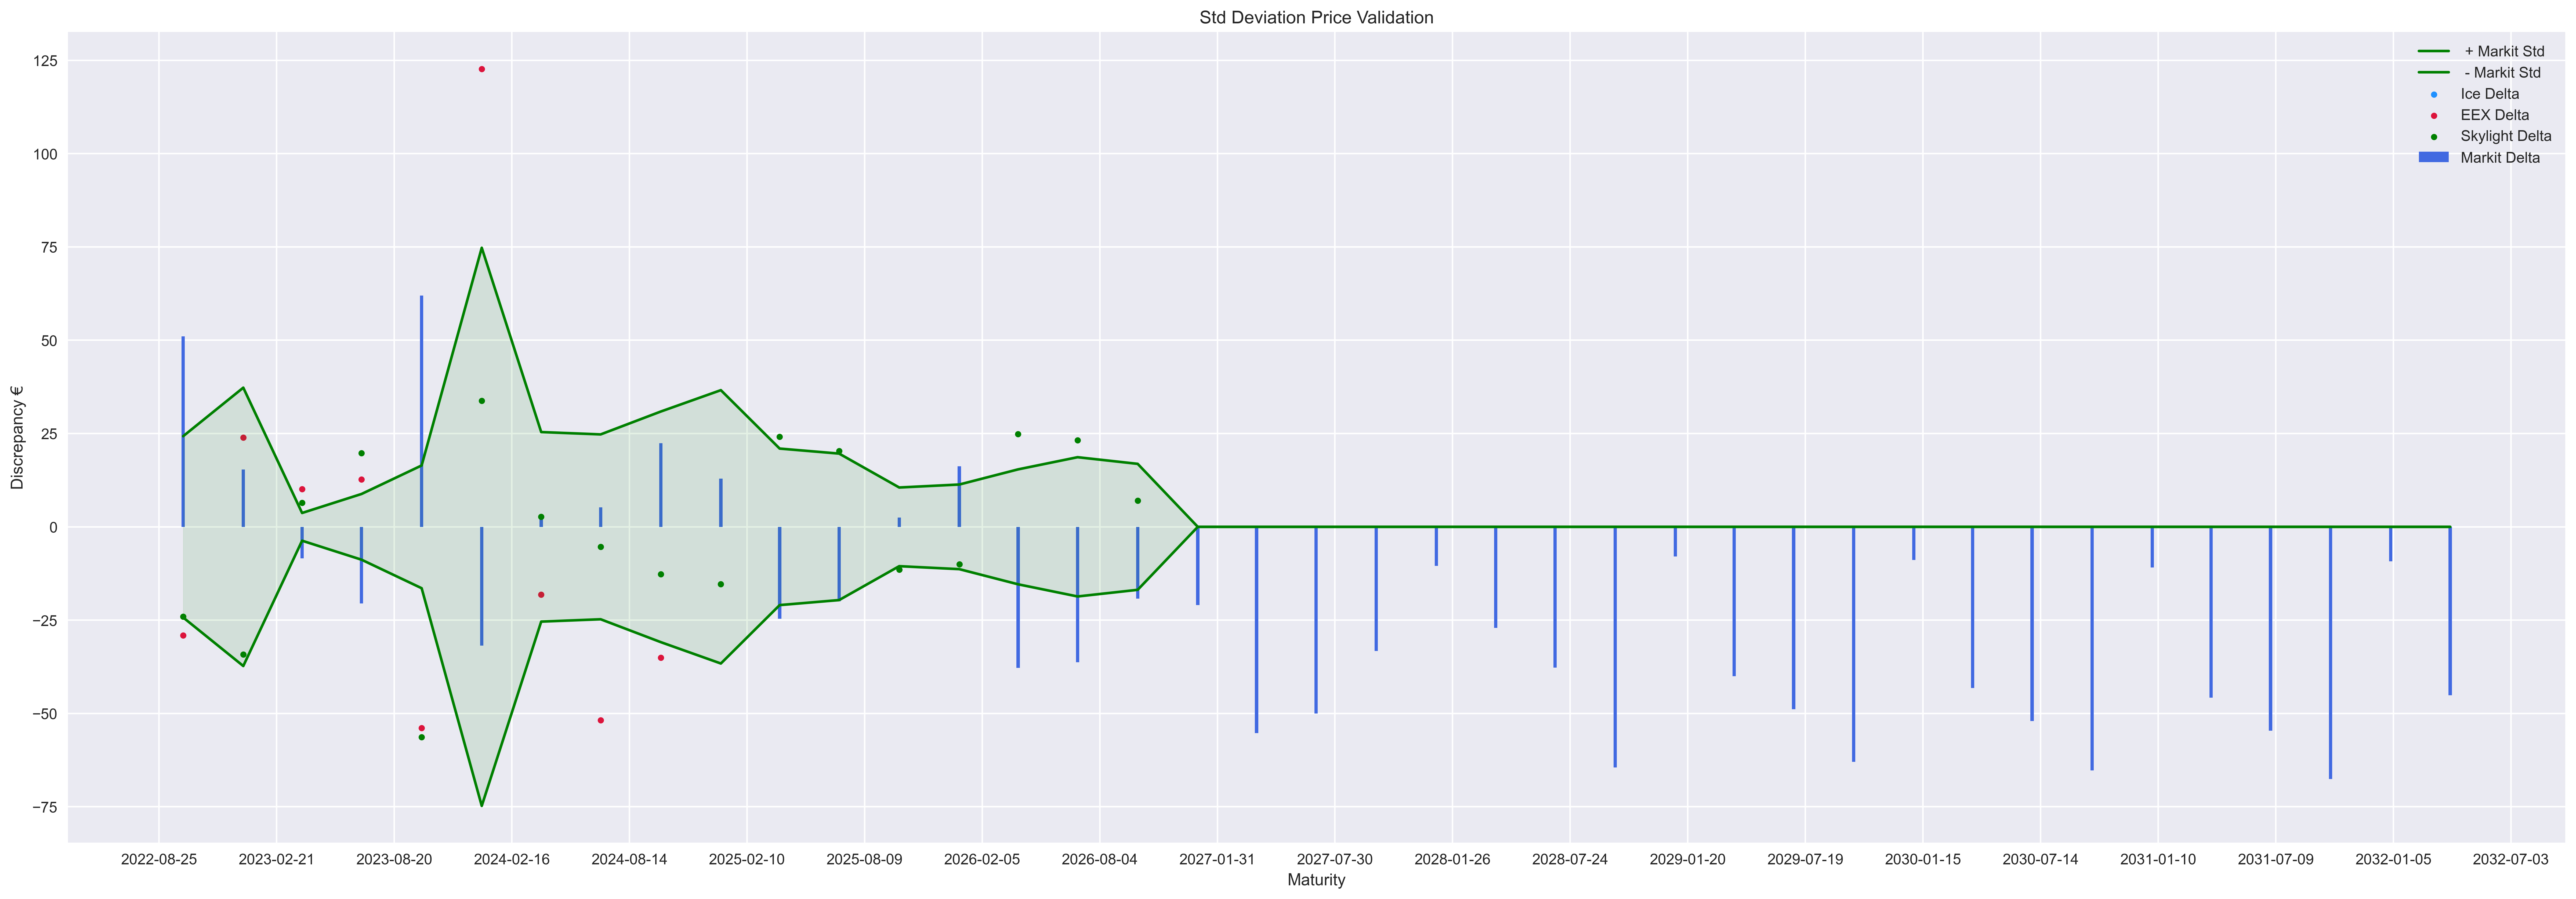

In [207]:
plt.figure(figsize = (30, 10), dpi = 400)
plt.bar(France_bl["start_date"] , France_bl["Markit Delta"], width = 5 ,  label = "Markit Delta", color = 'royalblue')
plt.plot(France_bl["start_date"] , France_bl["Markit Std"], label = " + Markit Std",  color = 'g')
plt.plot(France_bl["start_date"] , -France_bl["Markit Std"], label = " - Markit Std",  color = 'g')
plt.scatter(France_bl["start_date"] , -France_bl["Ice Delta"], label = "Ice Delta",  color = 'dodgerblue', marker = 'o', s = 15)
plt.scatter(France_bl["start_date"] , -France_bl["EEX Delta"], label = "EEX Delta",  color = 'crimson', marker = 'o', s = 15)
plt.scatter(France_bl["start_date"] , -France_bl["Skylight Delta"], label = "Skylight Delta",  color = 'g', marker = 'o', s = 15)
plt.fill_between(France_bl["start_date"], France_bl["Markit Std"], -France_bl["Markit Std"] , alpha = 0.1, color = 'g')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 180))
plt.title("Std Deviation Price Validation")
plt.xlabel("Maturity")
plt.ylabel("Discrepancy €")
plt.legend();